In [163]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from utils.ticker_data import get_stock_data
from utils.modelling import gbm, gbm_nl

c:\Users\borishan\Desktop\ml\code\ml_vs_baseline_reits\utils\ticker_data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


# of datapoints : 247


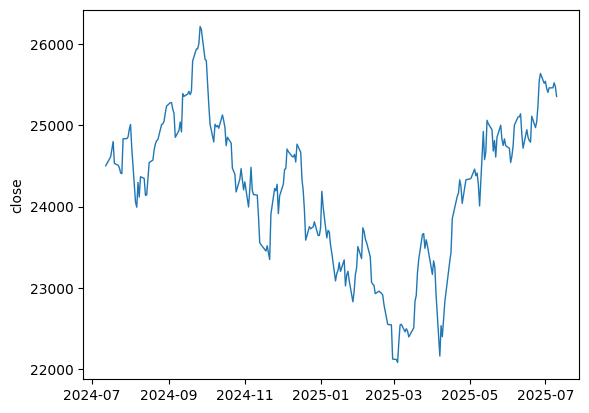

In [173]:
df = get_stock_data("^NSEI")
print(f"# of datapoints : {len(df)}")
plt.ylabel("close")
plt.plot(df.Date, df.Close, lw = 1)
plt.show()

In [174]:
def draw_with_fit(plt, df, dist):
    plt.hist(df, bins = len(df)//20, density=True)
    xstart, xend = plt.xlim()
    x = np.linspace(xstart, xend, 500)
    plt.plot(x, dist.pdf(x, *dist.fit(df)), lw = 1, c = 'r')

ks stat 0.0669 p-value: 0.20916622050015943


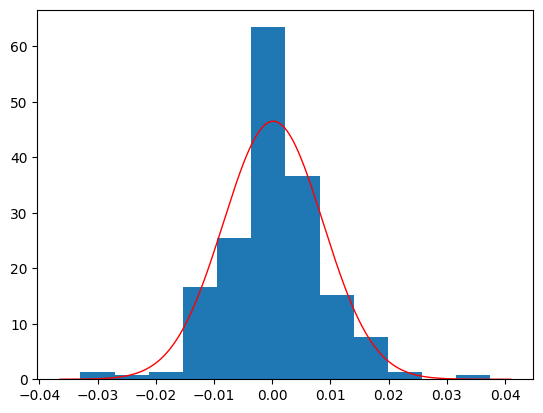

In [175]:
returns = df.Returns
stat, pval = stats.kstest(returns, 'norm', 
                          args=(returns.mean(), returns.std()))

print(f"ks stat {stat:.4f} p-value: {pval}")

draw_with_fit(plt, returns, stats.norm)

### simulating stock movement using Geometric Brownian Motion
we can explore variations over this (see [Simulating stock prices using geometric Brownian motion model under normal and convoluted distributional assumptions](https://www.sciencedirect.com/science/article/pii/S2468227623000157))

In [179]:
N = len(returns)
S0 = df.Close[0]
mu, std = df.Returns.mean() * N, df.Returns.std() * np.sqrt(N)
dt = 1/ N

(N, S0, mu, std)

(247,
 np.float64(24502.150390625),
 np.float64(0.04185332769054933),
 np.float64(0.13506089579348377))

MAPE: 7.263 %


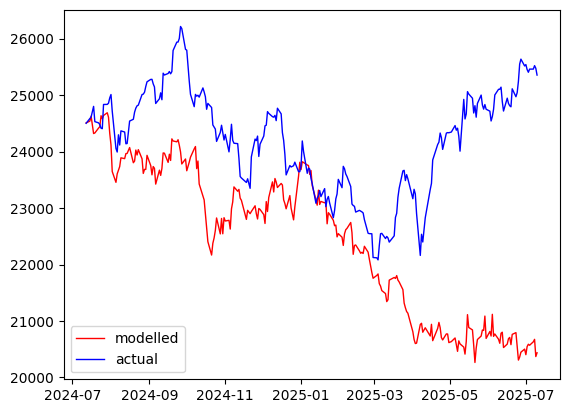

<Figure size 640x480 with 0 Axes>

In [183]:
prices = gbm_nl(S0, mu = mu, sigma=std, N=N)
mape = 100 * np.sum(np.abs(prices - df.Close)/df.Close)/len(prices)
print(f"MAPE: {mape:.3f} %")

plt.plot(df.Date, prices, lw = 1, c= 'r', label= "modelled")
plt.plot(df.Date, df.Close, lw = 1, c= 'b', label="actual")
plt.legend()
plt.figure("movement modelled by gbm model")
plt.show()

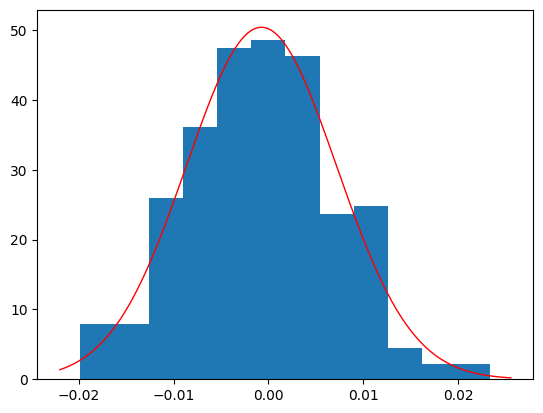

In [184]:
modelled_returns = np.log(prices[1:] / prices[:-1])
draw_with_fit(plt, modelled_returns, stats.norm)

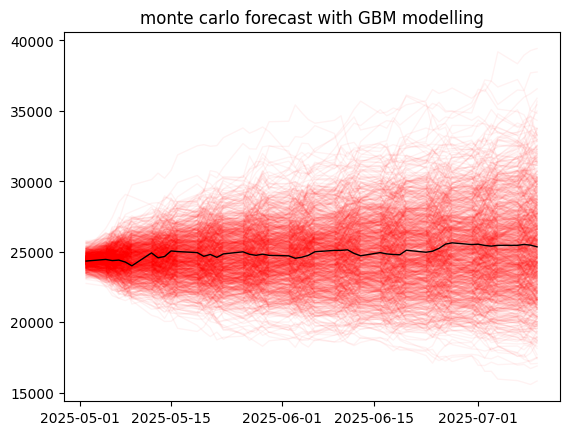

In [194]:
N = 50
# dates = pd.bdate_range(start=df.Date.iloc[-1] + pd.Timedelta(days=1),periods=N)
for _ in range(1000):
    plt.plot(df.Date.iloc[-N:],gbm(df.Close.iloc[-N], mu = mu, sigma=std, N=N), lw = 1, c= 'r', alpha = 0.05)
    # plt.plot(dates, gbm(df.Close.iloc[-1], mu = mu, sigma=std, N=N), lw = 1, c= 'r', alpha = 0.1)
plt.plot(df.Date.iloc[-N:],df.Close.iloc[-N:], lw  = 1, c = 'k')
plt.title("monte carlo forecast with GBM modelling")
plt.show()

### Modeling with GBM and returns drawn from Laplace distrib

log returns seem to be better explained by a laplace distribution 

**TODO** : Check literature supporting this

c:\Users\borishan\Desktop\ml\code\ml_vs_baseline_reits\utils\ticker_data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


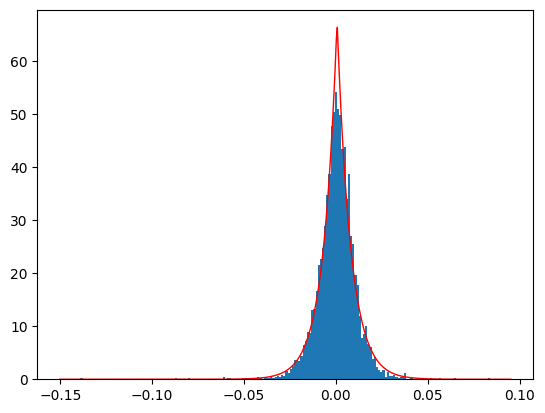

In [85]:
df = get_stock_data("^NSEI", "2010-01-01")
draw_with_fit(plt, df.Returns, stats.laplace)

In [88]:
N = len(df.Returns)
S0 = df.Close[0]
mu, std = df.Returns.mean() * N, df.Returns.std() * np.sqrt(N)
(N, S0, mu, std)

(3809,
 np.float64(5277.89990234375),
 np.float64(1.5781539321336115),
 np.float64(0.6517824305756946))

MAPE: 23.186 %


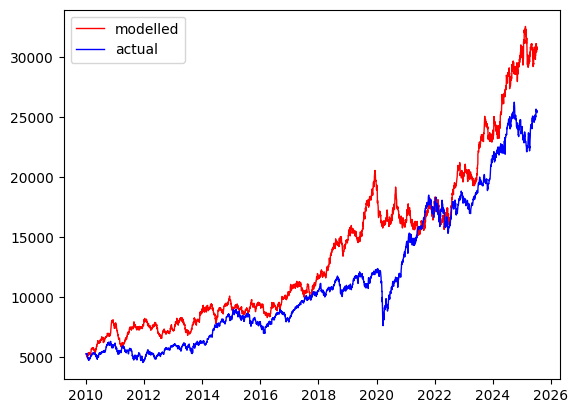

<Figure size 640x480 with 0 Axes>

In [152]:
prices_gbml = gbm_nl(S0, mu, std, N, normal_weight = 0.35)
mape = 100 * np.sum(np.abs(prices_gbml - df.Close)/df.Close)/len(prices_gbml)
print(f"MAPE: {mape:.3f} %")

plt.plot(df.Date, prices_gbml, lw = 1, c= 'r', label= "modelled")
plt.plot(df.Date, df.Close, lw = 1, c= 'b', label="actual")
plt.legend()
plt.figure("movement modelled by gbm with laplace")
plt.show()

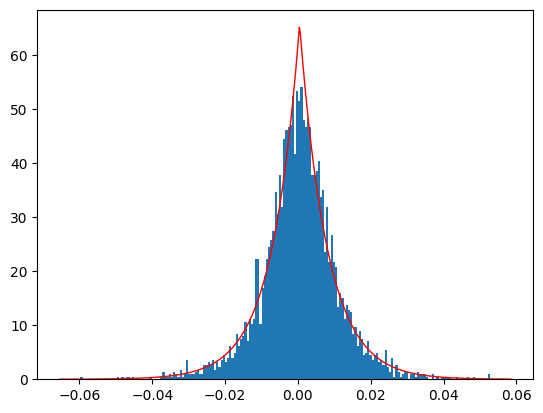

In [153]:
modelled_returns = np.log(prices_gbml[1:] / prices_gbml[:-1])
draw_with_fit(plt, modelled_returns, stats.laplace)
plt.show()

modelled mean= 0.0004635735405594696, std=0.01046895821601815
actual mean= 0.0004143223765118434, std=0.010560808391384534


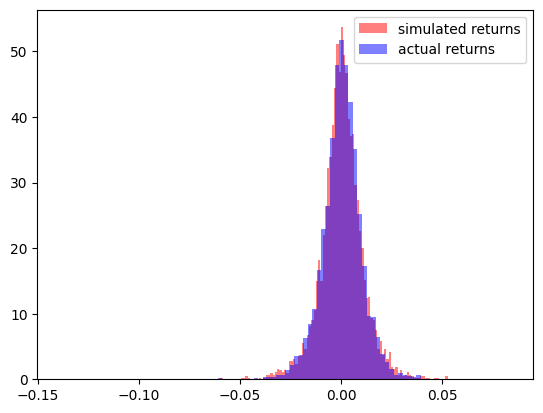

In [154]:
print(f"modelled mean= {modelled_returns.mean()}, std={modelled_returns.std()}")
print(f"actual mean= {df.Returns.mean()}, std={df.Returns.std()}")

plt.hist(modelled_returns, bins = 100, alpha = 0.5, density=True, color='r', label="simulated returns")
plt.hist(df.Returns, bins = 100, alpha = 0.5, density=True, color='b', label = "actual returns")
plt.legend()
plt.show()

In [207]:
returns = df.Returns
extreme_returns = returns[np.abs(returns) > .64 * returns.std()]
laplace_fraction = len(extreme_returns) / len(returns)

laplace_fraction
normal_weight = 1 - 1.5 * laplace_fraction 
normal_weight

0.35627530364372473